In [1]:
import os
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
data = pd.read_csv('IMDB_Dataset.csv')

In [3]:
data.shape

(50000, 2)

In [4]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
labeling = {
    'positive':1, 
    'negative':0
}

data['sentiment'] = data['sentiment'].apply(lambda x : labeling[x])


data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


<AxesSubplot:xlabel='sentiment'>

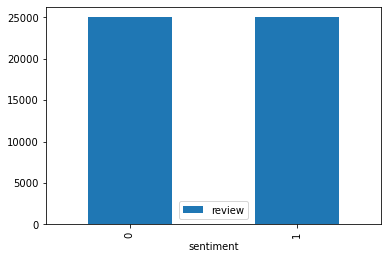

In [7]:
# Sentiment distribution
data.groupby('sentiment').count().plot(kind='bar')

<AxesSubplot:>

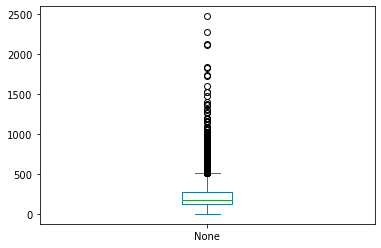

In [8]:
# Review lengths
review_len = pd.Series([len(review.split()) for review in data['review']])

# Review text length distribution
review_len.plot(kind='box')

<AxesSubplot:ylabel='Count'>

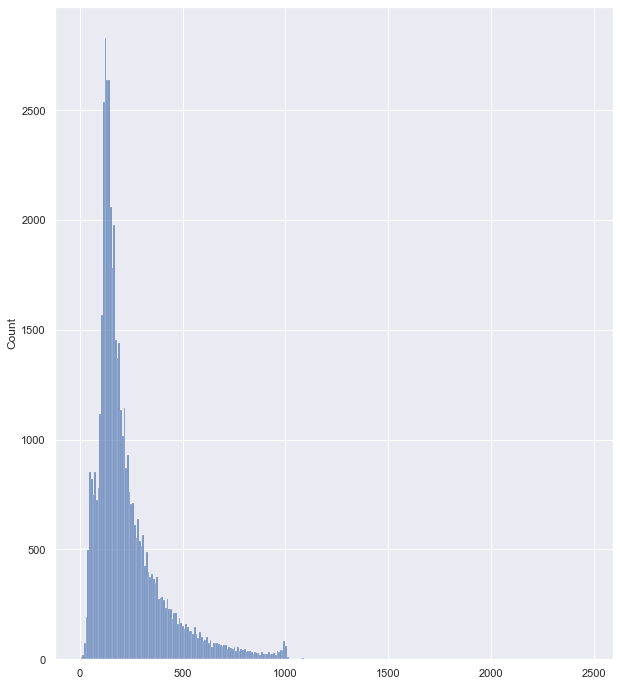

In [9]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

plt.figure(figsize = (10,12))
sns.histplot(review_len)

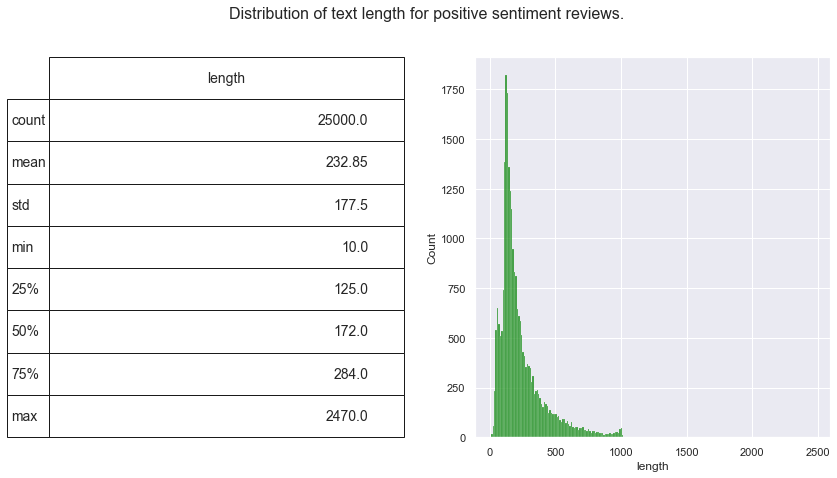

In [10]:
fig = plt.figure(figsize=(14,7))
data['length'] = data.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==1]['length'], ax=ax1,color='green')
describe = data.length[data.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

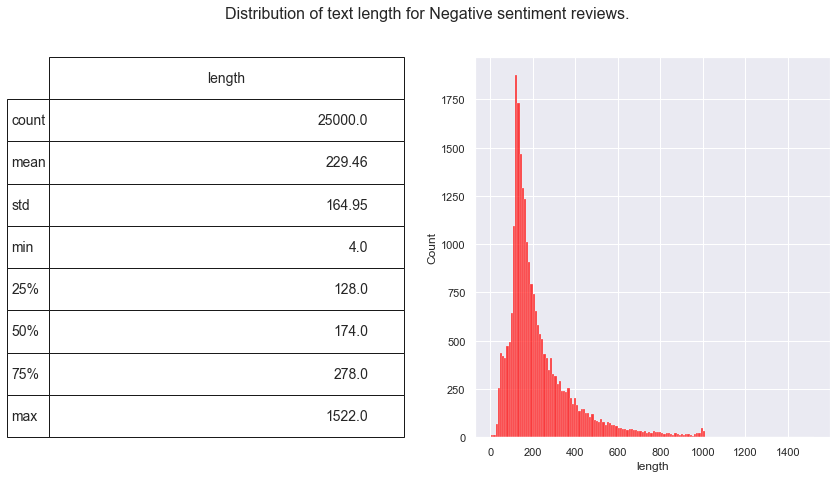

In [11]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==0]['length'], ax=ax1,color='red')
describe = data.length[data.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()

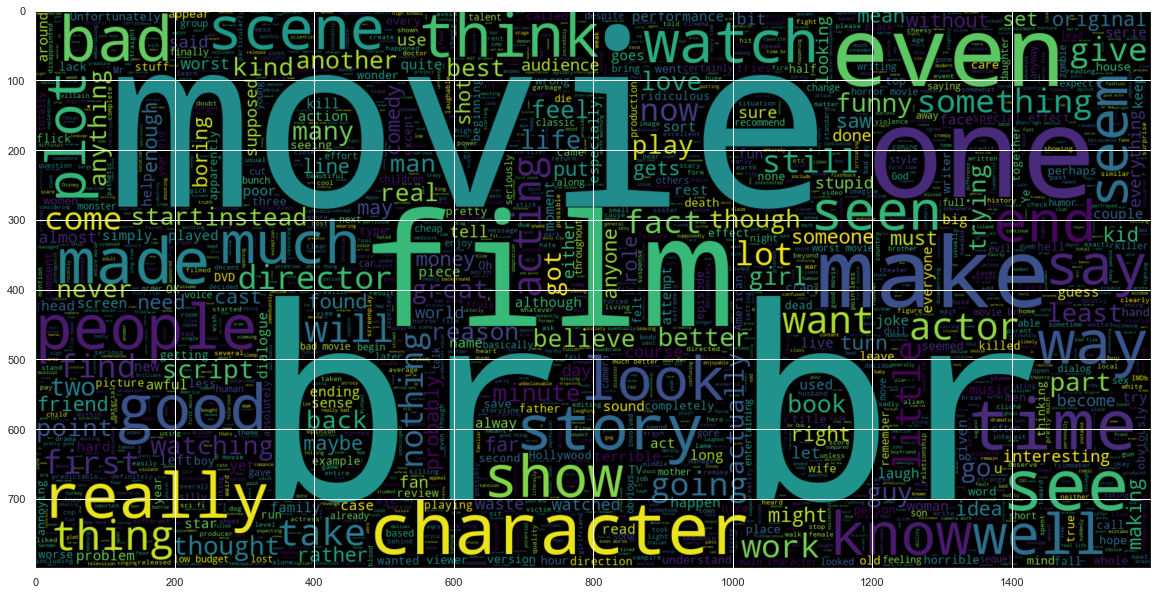

In [12]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

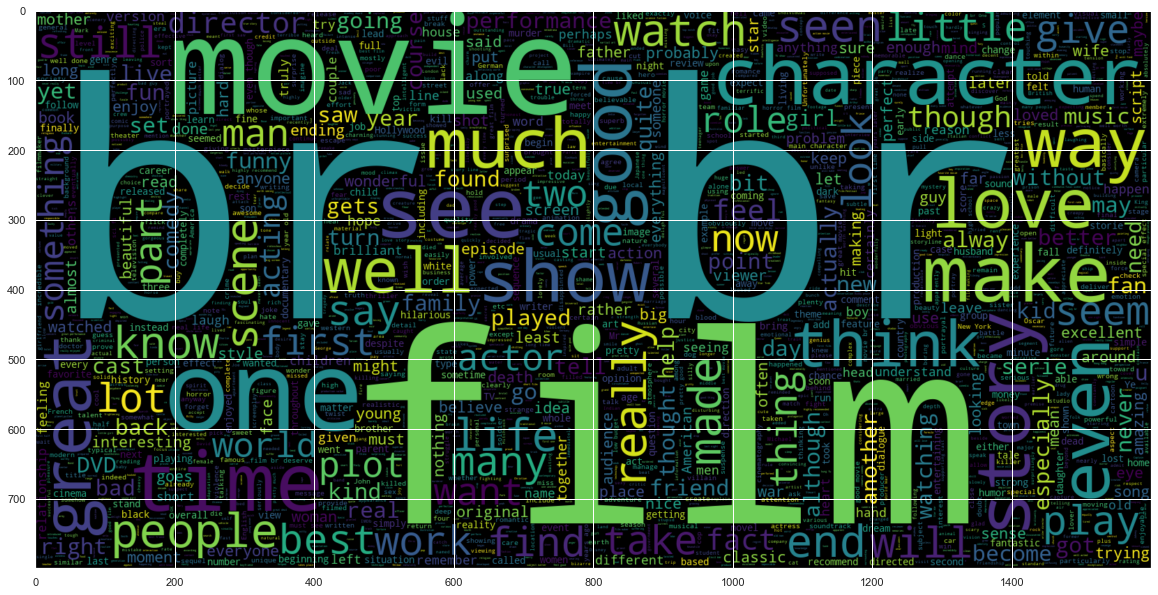

In [13]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [15]:
all_reviews = ' '.join(data['review'].str.lower())

In [16]:
wordcloud = WordCloud(background_color="white", max_words=100).generate(all_reviews)

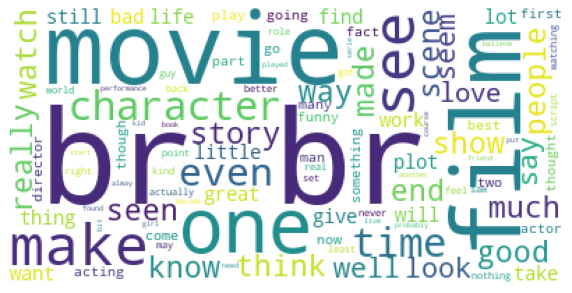

In [17]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [19]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-12-08 14:04:55.012937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [22]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [23]:
classifier_model = build_classifier_model()

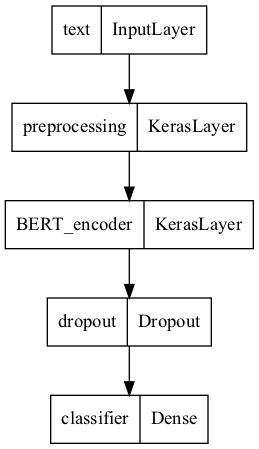

In [25]:
tf.keras.utils.plot_model(classifier_model)